# Classifier cross-validation

### Goals of this script
1. import labels (already trimmed but not shifted)
2. shift labels to account for hemodynamic lag
3. load voxel x TR matrix for ROI(s) of interest
4. reshape data (remove all fixation timepoints)
5. run classifiers and cross-validate on other localizer run (train on run1, test on run2 and vice-versa)
    - model 1: solver='liblinear', class_weight=None
    - model 2: solver='liblinear', class_weight='balanced'
    - model 3: solver='lbfgs', class_weight=None
    - model 4: solver='lbfgs', class_weight='balanced'
6. For each subject, save the average prediction probabilities for each classifier as well as the TR-by-TR prediction probabilities.
    - classifier=['face_classifier', 'scene_classifier', 'object_classifier']
    - trial_type=['face_trials', 'scene_trials', 'object_trials']
        - classifier_scores[classifier][mask][run]
        - prediction_probabilities[classifier][mask][TR]
        - avg_classifier_evidence[trial_type][mask][run][classifier]
        - num_voxels[mask]

## Define subject

In [1]:
sub = 'sub-005'
subNum = '005'
ses = 'ses-01'
task = 'localizer'

n_trunc_beginning=14 #Number of volumes to trim from beginning of run
n_trunc_end=10 #Number of volumes to trim from end of run
ROIs=['bilateral_hippo']

## Import necessary packages

In [2]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
import nibabel as nib
import nilearn
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
from nilearn.masking import intersect_masks
from nilearn import image
from nilearn import plotting
from nilearn.plotting import plot_roi
from scipy import stats
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import scipy.io
#from mpi4py import MPI
import os
import pickle 
import time
from scipy.sparse import random
from scipy.stats import zscore
from scipy.spatial.distance import euclidean
from pathlib import Path
from shutil import copyfile
import seaborn as sns
import importlib

# Import machine learning libraries
import sklearn
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, PredefinedSplit
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

%matplotlib inline 
%autosave 5

Autosaving every 5 seconds


In [3]:
from platform import python_version
print('The python version is {}.'.format(python_version()))
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The numpy version is {}.'.format(np.__version__))
print('The nilearn version is {}.'.format(nilearn.__version__))
print('The seaborn version is {}.'.format(sns.__version__))

The python version is 3.9.10.
The scikit-learn version is 1.0.2.
The numpy version is 1.20.3.
The nilearn version is 0.8.1.
The seaborn version is 0.11.2.


## Load settings

In [4]:
# Set printing precision
np.set_printoptions(precision=2, suppress=True)

# load some helper functions
sys.path.insert(0, '/jukebox/norman/karina/adderzip_fMRI/adderzip/code/mainanalysis')
import adderzip_utils
from adderzip_utils import load_adderzip_stim_labels_localizer,load_adderzip_epi_data, shift_timing, label2TR, mask_data

importlib.reload(adderzip_utils)

# load some constants
from adderzip_utils import adderzip_dir, adderzip_bids_dir, adderzip_label_dict, n_runs, run_names, adderzip_TR, adderzip_hrf_lag, TRs_run

print('TASKS:', task)
print('LIST OF ALL TASKS:', run_names)
task_index = run_names.index(task)
print('task index:', task_index)
print('')

n_runs_localizer = n_runs[task_index]

TRs_run_localizer=TRs_run[task_index]-n_trunc_beginning-n_trunc_end

trials_run_localizer = 90

anat_dir=adderzip_bids_dir + 'derivatives/deface/'
out_dir= adderzip_bids_dir + 'derivatives/firstlevel/%s/' % sub
#mask_fold_other = adderzip_bids_dir + 'derivatives/firstlevel/%s/masks/' % sub
mask_fold_hipp = adderzip_bids_dir + 'derivatives/firstlevel/%s/masks/' % sub
data_dir='/jukebox/norman/karina/adderzip_fMRI/adderzip/data/mainanalysis/output'

#ses0_dir=adderzip_bids_dir + 'derivatives/fmriprep/%s/ses-00/func/' % sub
ses1_dir=adderzip_bids_dir + 'derivatives/fmriprep/%s/ses-01/func/' % sub
#ses2_dir=adderzip_bids_dir + 'derivatives/fmriprep/%s/ses-02/func/' % sub

print('bids dir = %s' % (adderzip_bids_dir))
print('')
print('subject dir = %s' % (ses1_dir))
print('')
print('output dir = %s' % (out_dir))
print('')
print('ROIs = %s' % (ROIs))
print('Labels = %s' % (adderzip_label_dict))
print('number of runs = %d' % (n_runs_localizer))
print('TR = %s seconds' % (adderzip_TR))
print('TRs per run before trimming = %s' % (TRs_run[task_index]))
print('%d volumes trimmed from beginning of each run' % (n_trunc_beginning))
print('%d volumes trimmed from end of each run' % (n_trunc_end))
print('TRs per run after trimming = %s' % (TRs_run_localizer))

TASKS: localizer
LIST OF ALL TASKS: ['localizer']
task index: 0

bids dir = /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/

subject dir = /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/derivatives/fmriprep/sub-005/ses-01/func/

output dir = /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/derivatives/firstlevel/sub-005/

ROIs = ['bilateral_hippo']
Labels = {1: 'Faces', 2: 'Scenes', 3: 'Objects', 0: 'Rest'}
number of runs = 3
TR = 1.5 seconds
TRs per run before trimming = 194
14 volumes trimmed from beginning of each run
10 volumes trimmed from end of each run
TRs per run after trimming = 170


## Stimulus labels  - load truncated stimulus labels and shift labels 4.5 sec (3 TRs)

stim_label_allruns has shape:  (271, 8)

stim_label_allruns looks like this
[['# trial' 'run' 'block' 'imCat' 'repeat' 'imID' 'targetOnset'
  'targetOffset']
 ['0' '0' '0' '2' '0' '1' '15.000000' '16.500000']
 ['1' '0' '0' '2' '0' '2' '16.500000' '18.000000']
 ['2' '0' '0' '2' '0' '3' '18.000000' '19.500000']
 ['3' '0' '0' '2' '0' '4' '19.500000' '21.000000']]
...
[['265' '2' '8' '0' '0' '69' '262.500000' '264.000000']
 ['266' '2' '8' '0' '1' '69' '264.000000' '265.500000']
 ['267' '2' '8' '0' '0' '70' '265.500000' '267.000000']
 ['268' '2' '8' '0' '0' '71' '267.000000' '268.500000']
 ['269' '2' '8' '0' '0' '72' '268.500000' '270.000000']]


Text(0.5, 0, 'Trial')

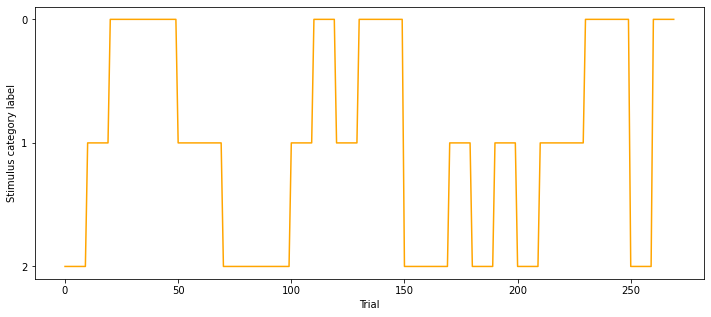

In [19]:
# load stimulus labels from regressor file for each run and concatenate
# NOTE: Regressor files are already trimmed (beginning only), but not shifted, in Matlab using gen_loc_regressor_0101.m

stim_label = [];
stim_label_allruns = [];

stim_label_allruns = load_adderzip_stim_labels_localizer(subNum)
        
print('stim_label_allruns has shape: ', np.shape(stim_label_allruns))
print('')
print('stim_label_allruns looks like this')
print(stim_label_allruns[:5,:])
print('...')
print(stim_label_allruns[-5:,:])


# Plot the labels
f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(stim_label_allruns[1:,3], c='orange')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('Trial')

original shape (271, 12)

stim_label_allruns looks like this
[['# trial' 'run' 'block' 'imCat' 'repeat' 'imID' 'targetOnset'
  'targetOffset' '0.0' '0.0' '0.0' '0.0']
 ['0' '0' '0' '2' '0' '1' '15.000000' '16.500000' '3.0' '22.5' '1.0'
  '1.0']
 ['1' '0' '0' '2' '0' '2' '16.500000' '18.000000' '3.0' '24.0' '2.0'
  '2.0']
 ['2' '0' '0' '2' '0' '3' '18.000000' '19.500000' '3.0' '25.5' '3.0'
  '3.0']
 ['3' '0' '0' '2' '0' '4' '19.500000' '21.000000' '3.0' '27.0' '4.0'
  '4.0']]
...
[['265' '2' '8' '0' '0' '69' '262.500000' '264.000000' '1.0' '270.0'
  '166.0' '506.0']
 ['266' '2' '8' '0' '1' '69' '264.000000' '265.500000' '1.0' '271.5'
  '167.0' '507.0']
 ['267' '2' '8' '0' '0' '70' '265.500000' '267.000000' '1.0' '273.0'
  '168.0' '508.0']
 ['268' '2' '8' '0' '0' '71' '267.000000' '268.500000' '1.0' '274.5'
  '169.0' '509.0']
 ['269' '2' '8' '0' '0' '72' '268.500000' '270.000000' '1.0' '276.0'
  '170.0' '510.0']]


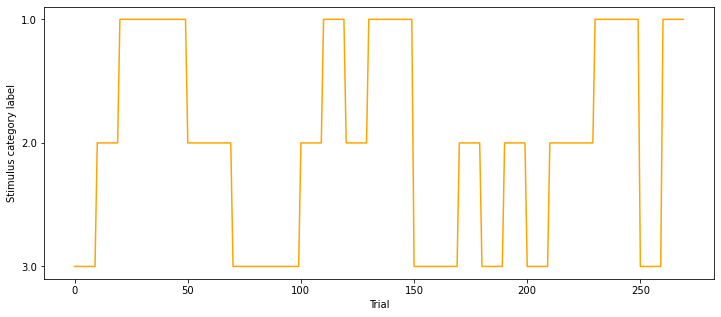

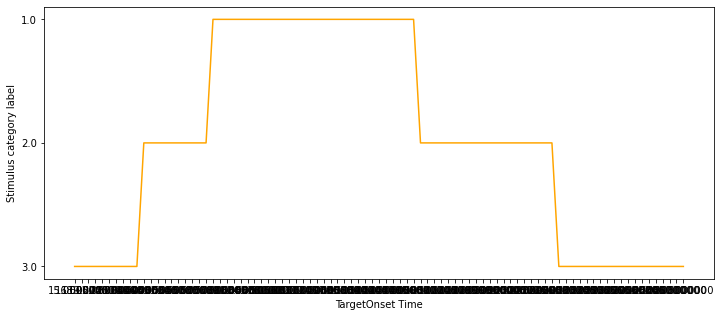

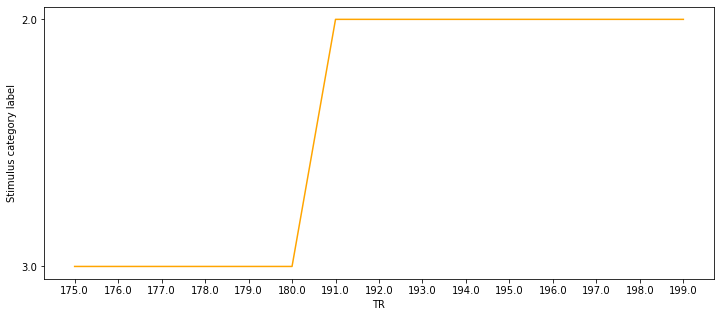

In [24]:
#reshape and edit stim labels format
print('original shape', np.shape(stim_label_allruns))

#image category is 0, 1, 2. change to 1,2,3
if stim_label_allruns.shape[1]==8:
    imCat = stim_label_allruns[1:,3] 
    ones = np.ones(int(np.shape(imCat)[0]))
    ones = np.float64(ones)
    imCat = np.float64(imCat)
    newCol_imCat = imCat + ones
    zeros = np.zeros((int(np.shape(imCat)[0]+1),1))
    stim_label_allruns = np.hstack((stim_label_allruns,zeros))
    stim_label_allruns[1:,8] = newCol_imCat

    print('new shape after adding new column with changesd imCat labels', np.shape(stim_label_allruns))

# Plot the labels
f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(stim_label_allruns[1:,8], c='orange')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('Trial')

# Plot the labels for 1st run
f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(stim_label_allruns[1:90,6],stim_label_allruns[1:90,8], c='orange')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('TargetOnset Time')

#targetOnset has an error. Fix by adding 7.5sec delay
if stim_label_allruns.shape[1]==9:
    stim_label_allruns = np.hstack((stim_label_allruns,zeros))
    
    targetOnset = np.float64(stim_label_allruns[1:,6])
    ones = np.ones(stim_label_allruns.shape[0]-1)
    delay = np.float64(ones * 7.5)
    newTargetOnset = targetOnset + delay
    
    #print('newCol_targetOnset',newCol_targetOnset)
    stim_label_allruns[1:,9] = newTargetOnset

    print('new shape after adding new column with 7.5 sec delay', np.shape(stim_label_allruns))

#change targetOnset time to TR
#truncate initial 
if stim_label_allruns.shape[1]==10:
    stim_label_allruns = np.hstack((stim_label_allruns,zeros))
    newCol_TR = np.float64(stim_label_allruns[1:,9])
    newCol_TR = newCol_TR / np.float64(adderzip_TR)
    
    newCol_TR = newCol_TR - np.float64(ones * n_trunc_beginning)
    
    stim_label_allruns[1:,10] = newCol_TR

    print('new shape after adding new column with trimmed TRs', np.shape(stim_label_allruns))

#targetOnset starts count at each run. Make it continuous
if stim_label_allruns.shape[1]==11:
    stim_label_allruns = np.hstack((stim_label_allruns,zeros))
    for eachRun in range(n_runs_localizer):
        start = trials_run_localizer*eachRun + 1
        end = start + trials_run_localizer
        TRs_thisRun = np.float64(stim_label_allruns[start:end,10])
        cont_diff = np.ones(trials_run_localizer)
        cont_diff = np.float64(cont_diff * TRs_run_localizer)
        new_TRs_thisRun = TRs_thisRun + cont_diff*eachRun

        if eachRun == 0:
            newCol_TRs = new_TRs_thisRun
        else:
            newCol_TRs = np.hstack((newCol_TRs,new_TRs_thisRun))
        
    stim_label_allruns[1:,11] = newCol_TRs
    
    print('new shape after adding new column with continuous TRs', np.shape(stim_label_allruns))

# Plot the labels 
f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(stim_label_allruns[95:110,11],stim_label_allruns[95:110,8], c='orange')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('TR')

print('')
print('stim_label_allruns looks like this')
print(stim_label_allruns[:5,:])
print('...')
print(stim_label_allruns[-5:,:])


shift by 3 TRs
stim_label_allruns_shifted shape (271, 12)

stim_label_allruns looks like this
[['# trial' 'run' 'block' 'imCat' 'repeat' 'imID' 'targetOnset'
  'targetOffset' '0.0' '0.0' '0.0' '0.0']
 ['0' '0' '0' '2' '0' '1' '15.000000' '16.500000' '3.0' '22.5' '1.0'
  '4.0']
 ['1' '0' '0' '2' '0' '2' '16.500000' '18.000000' '3.0' '24.0' '2.0'
  '5.0']
 ['2' '0' '0' '2' '0' '3' '18.000000' '19.500000' '3.0' '25.5' '3.0'
  '6.0']
 ['3' '0' '0' '2' '0' '4' '19.500000' '21.000000' '3.0' '27.0' '4.0'
  '7.0']]
[['265' '2' '8' '0' '0' '69' '262.500000' '264.000000' '1.0' '270.0'
  '166.0' '509.0']
 ['266' '2' '8' '0' '1' '69' '264.000000' '265.500000' '1.0' '271.5'
  '167.0' '0.0']
 ['267' '2' '8' '0' '0' '70' '265.500000' '267.000000' '1.0' '273.0'
  '168.0' '0.0']
 ['268' '2' '8' '0' '0' '71' '267.000000' '268.500000' '1.0' '274.5'
  '169.0' '0.0']
 ['269' '2' '8' '0' '0' '72' '268.500000' '270.000000' '1.0' '276.0'
  '170.0' '0.0']]


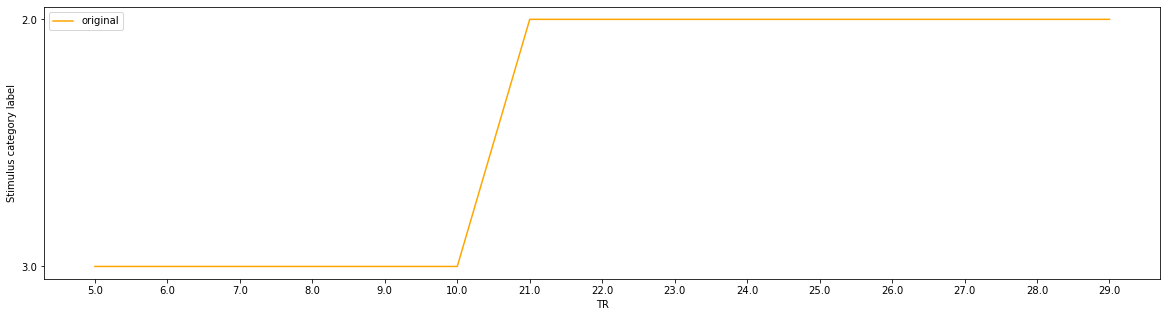

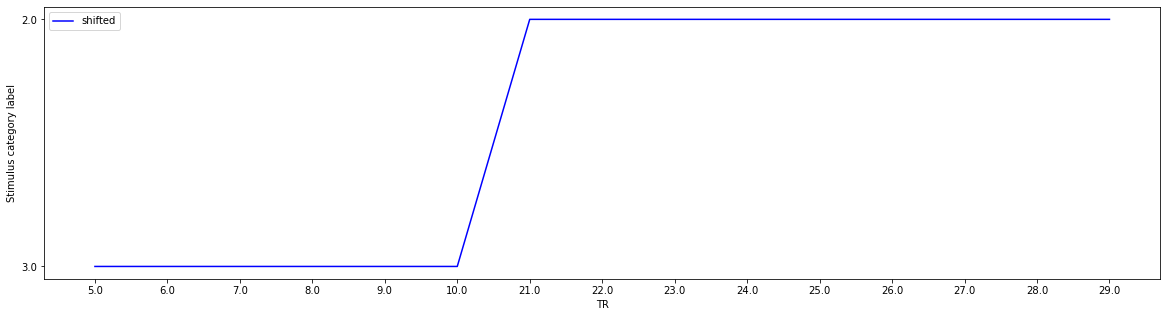

In [41]:
# Shift the data labels to account for hemodynamic lag
shift_size = int(adderzip_hrf_lag / adderzip_TR)  # Convert the shift into TRs
print('shift by %s TRs' % (shift_size))

#add shift to TRs
TRs = stim_label_allruns[1:,11] 
ones = np.ones(int(np.shape(TRs)[0]))
shiftBy = ones * shift_size
shiftBy = np.float64(shiftBy)
TRs = np.float64(TRs)
shiftedTRs = TRs + shiftBy
shiftBy = int(shift_size+1) #last TR from last run also got truncated from bold data
shiftedTRs[-shiftBy:] = 0
stim_label_allruns_shifted = np.copy(stim_label_allruns)
stim_label_allruns_shifted[1:,11] = shiftedTRs
       
#stim_label_allruns_shifted = np.hstack((stim_label_allruns,zeros))
#stim_label_allruns[1:,11] = newCol_shiftedTR

# Plot the original and shifted labels
f, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(stim_label_allruns[95:110,10],stim_label_allruns[95:110,8], label='original', c='orange')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('TR')
ax.legend()

f, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(stim_label_allruns_shifted[95:110,10],stim_label_allruns_shifted[95:110,8], label='shifted', c='blue')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('TR')
ax.legend()

print('stim_label_allruns_shifted shape', np.shape(stim_label_allruns_shifted))
np.savetxt('/jukebox/norman/karina/adderzip_fMRI/adderzip/data/behavioral/info_processed_v1/locInfo/locInfo_005.csv',stim_label_allruns_shifted[1:,:],fmt='%10s',delimiter=",")

print('')
print('stim_label_allruns looks like this')
print(stim_label_allruns_shifted[:5,:])
print(stim_label_allruns_shifted[-5:,:])

## OR if voxel x TR matrix already exists, load matrix:

In [42]:
# load defaced T1 image (merged T1 from fmriprep)
t1_file = anat_dir + sub +'_' +ses + '_desc-preproc_T1w_defaced.nii.gz'
t1_img = image.load_img(t1_file) 

# Make a function to load the mask data
def load_adderzip_mask(ROI_name, sub):
    """Load the mask for the svd data 
    Parameters
    ----------
    ROI_name: string
    sub: string 
    
    Return
    ----------
    the requested mask
    """    
    # load the mask
    if ROI_name == 'bilateral_hippo':
        #mask_fold=mask_fold_other
    #else:
        mask_fold=mask_fold_hipp
    maskfile = (mask_fold + sub + "_%s.nii.gz" % (ROI_name))
    mask = nib.load(maskfile)
    print("Loaded mask: %s" % (ROI_name))
    return mask

Loaded mask: bilateral_hippo


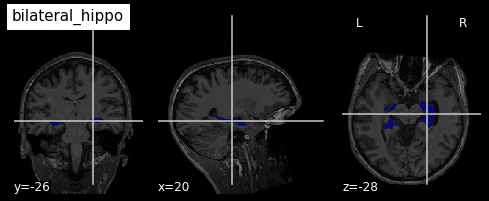

In [43]:
# load voxel x TR data for each ROI
mask_list = ROIs
masked_data = []
masked_data_all = [0] * len(mask_list)

for mask_counter in range(len(mask_list)):
        # load the mask for the corresponding ROI
        this_mask = mask_list[mask_counter]
        
        if this_mask == 'bilateral_hippo':
        #    mask_fold=mask_fold_other
        #else:
            mask_fold=mask_fold_hipp
        
        mask = load_adderzip_mask(mask_list[mask_counter], sub)
        
        # plot mask overlayed on subject's T1
        plot_roi(mask, bg_img=t1_img, title=this_mask)
        
        # Load in data from matlab
        in_file = (adderzip_bids_dir + 'derivatives/firstlevel/%s/masked_epi_data_v1/threshold-75/%s_task-%s_run-ALL_space-T1w_trim%dand%dTRs_mask-%s.mat' % (sub, sub, task, n_trunc_beginning, n_trunc_end, this_mask))
        masked_data = scipy.io.loadmat(in_file);
        masked_data = np.array(masked_data['data']);
        masked_data_all[mask_counter] = masked_data

voxel by TR matrix - shape:  bilateral_hippo (1950, 510)


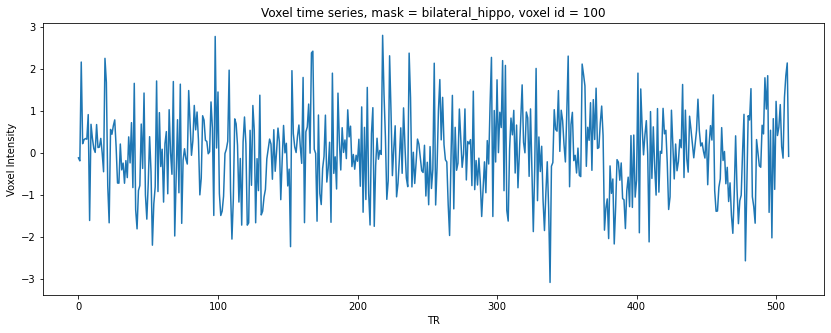

In [44]:
# check dimensionality of the data and plot value of voxel_id across timeseries; make sure data are z-scored 
num_voxels = [0] * len(mask_list)

voxel_id = 100
for mask_counter in range(len(mask_list)):
    this_mask = mask_list[mask_counter]
    print('voxel by TR matrix - shape: ', this_mask, masked_data_all[mask_counter].shape)
    num_voxels[mask_counter] = masked_data_all[mask_counter].shape[0] #save number of voxels in each mask
    
    f, ax = plt.subplots(1,1, figsize=(14,5))
    ax.plot(masked_data_all[mask_counter][voxel_id,:])

    ax.set_title('Voxel time series, mask = %s, voxel id = %d' % (this_mask, voxel_id))
    ax.set_xlabel('TR')
    ax.set_ylabel('Voxel Intensity')
    

## Reshape labels and data 
Extract the time points for which we have stimulus labels. For classifier B, we remove all rest TRs. 

In [45]:
# Extract bold data for non-zero labels
print('label list - shape: ', stim_label_allruns_shifted[1:,:].shape)

def reshape_data(stim_label_allruns_shifted, masked_data_roi):
    label_index = np.float64(stim_label_allruns_shifted[1:,11])
    label_index = label_index.astype(int)
    print(label_index)
    
    # Pull out the indexes
    indexed_data = np.transpose(masked_data_roi[:,label_index])
    nonzero_labels = stim_label_allruns_shifted[1:,8]
    return indexed_data, nonzero_labels

# Pull out the data from this ROI for these time points

for mask_counter in range(len(mask_list)):
        this_mask = mask_list[mask_counter]
        #print(this_mask)
        
        masked_data_roi = masked_data_all[mask_counter]
        
        bold_data, labels = reshape_data(stim_label_allruns_shifted, masked_data_roi)

        # What is the dimensionality of the data? We need the first dim to be the same
        print('The %s has the dimensionality of: %d time points by %d voxels' % (this_mask, bold_data.shape[0], bold_data.shape[1]))

label list - shape:  (270, 12)
[  4   5   6   7   8   9  10  11  12  13  24  25  26  27  28  29  30  31
  32  33  44  45  46  47  48  49  50  51  52  53  64  65  66  67  68  69
  70  71  72  73  84  85  86  87  88  89  90  91  92  93 104 105 106 107
 108 109 110 111 112 113 124 125 126 127 128 129 130 131 132 133 144 145
 146 147 148 149 150 151 152 153 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 194 195 196 197 198 199 200 201
 202 203 214 215 216 217 218 219 220 221 222 223 234 235 236 237 238 239
 240 241 242 243 254 255 256 257 258 259 260 261 262 263 274 275 276 277
 278 279 280 281 282 283 294 295 296 297 298 299 300 301 302 303 314 315
 316 317 318 319 320 321 322 323 334 335 336 337 338 339 340 341 342 343
 344 345 346 347 348 349 350 351 352 353 364 365 366 367 368 369 370 371
 372 373 384 385 386 387 388 389 390 391 392 393 404 405 406 407 408 409
 410 411 412 413 424 425 426 427 428 429 430 431 432 433 444 445 446 447
 448 449 450 451 452

In [47]:
#CONTINUE HERE 02/06/22
# How many labels corresponding to each category? 
print('Labels = %s' % (adderzip_label_dict))
find_zeros = np.where(labels[1:,:] == 0)[0] #to double check that numbers line up
find_ones = np.where(labels[1:,:] == 1)[0] #to double check that numbers line up
find_twos = np.where(labels[1:,:] == 2)[0] #to double check that numbers line up
find_threes = np.where(labels[1:,:] == 3)[0] #to double check that numbers line up
print("number of rest timepoints:", find_zeros.shape[0])
print("number of face timepoints:", find_ones.shape[0])
print("number of scene timepoints:", find_twos.shape[0])
print("number of object timepoints:", find_threes.shape[0])

Labels = {1: 'Faces', 2: 'Scenes', 3: 'Objects', 0: 'Rest'}


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
# Create 4 sets of labels: faces vs. non-faces, scenes vs. non-scenes, objects vs. non-objects, rest vs. non-rest

labels = reshaped_labels[0,:]
timepoint = reshaped_labels[15,:]
labels_timepoints=np.vstack((labels, timepoint))
print('labels:', labels.size)
# print(labels)
print(labels.shape)

# faces
def numberfunc(x):
    if x == 1:
        return 1
    else:
        return 0

labels_faces = np.array(list(map(numberfunc, labels[:,])))

# scenes
def numberfunc(x):
    if x == 2:
        return 1
    else:
        return 0

labels_scenes = np.array(list(map(numberfunc, labels[:,])))

# objects
def numberfunc(x):
    if x == 3:
        return 1
    else:
        return 0

labels_objects = np.array(list(map(numberfunc, labels[:,])))

# # rest
# def numberfunc(x):
#     if x == 0:
#         return 1
#     else:
#         return 0

# labels_rest = np.array(list(map(numberfunc, labels[:,])))

# Plot the original and modified labels
f, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(labels, label='original', c='orange')
ax.plot(labels_faces, label='faces', c='blue')
ax.plot(labels_scenes, label='scenes', c='red')
ax.plot(labels_objects, label='objects', c='green')
# ax.plot(labels_rest, label='rest', c='gray')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('TR')
ax.legend()

## Classifier B - no rest

In [ ]:
# pack the classification code as a function... 
def decode(X, y, cv_ids, model): 
    """
    Parameters
    --------------
    X: np.array, n_stimuli x n_voxels
    y: np.array, n_stimuli, 
    cv_ids: np.array - n_stimuli, 
    
    Return
    --------------
    scores
    """
    scores = []
    models = []
    predictions = []
    prediction_probs = []
    y_actual = []
    y_test_index = []
    
    ps = PredefinedSplit(cv_ids) #split data
    scaler = StandardScaler()
    
    for train_index, test_index in ps.split():
#         print('TRAIN INDEX:', train_index)
#         print('TEST INDEX:', test_index)
        
        # split the data 
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # normalize the data 
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        # fit the model on the training set 
        model.fit(X_train, y_train)
        # calculate the accuracy for the hold out run
        score = model.score(X_test, y_test)
        # predict class labels for samples in X
        prediction = model.predict(X_test)
        prediction_prob = model.predict_proba(X_test)
#         print('PREDICTION PROBABILITIES:', prediction_prob)
        
        # save stuff 
        models.append(model)
        scores.append(score)
        predictions.append(prediction)
        prediction_probs.append(prediction_prob)
        y_actual.append(y_test)
        y_test_index.append(test_index)
        
    return models, scores, predictions, prediction_probs, y_actual, y_test_index

In [ ]:
# prepare run ids
n_runs = n_runs_localizer
run_len = labels.size // n_runs
run_ids = np.repeat(range(n_runs_localizer), run_len)
print('run length:', run_len)
print('run IDs:', run_ids)

In [ ]:
# make an instance of the model and set parameters
model_1 = LogisticRegression(C=1.0, random_state=34, solver='liblinear')
model_2 = LogisticRegression(C=1.0, random_state=34, solver='liblinear', class_weight='balanced')
model_3 = LogisticRegression(C=1.0, random_state=34, solver='lbfgs')
model_4 = LogisticRegression(C=1.0, random_state=34, solver='lbfgs', class_weight='balanced')

## Model 1

In [ ]:
mask_list=ROIs
category_list = ['faces', 'scenes', 'objects']

# classifier accuracy 
scores_faces = [0] * len(mask_list)
scores_scenes = [0] * len(mask_list)
scores_objects = [0] * len(mask_list)

# binary category prediction
predictions_faces = [0] * len(mask_list)
predictions_scenes = [0] * len(mask_list)
predictions_objects = [0] * len(mask_list)

# predict_proba
prediction_probs_faces = [0] * len(mask_list)
prediction_probs_scenes = [0] * len(mask_list)
prediction_probs_objects = [0] * len(mask_list)

y_actual_faces = [0] * len(mask_list)
y_actual_scenes = [0] * len(mask_list)
y_actual_objects = [0] * len(mask_list)

y_test_index_faces = [0] * len(mask_list)
y_test_index_scenes = [0] * len(mask_list)
y_test_index_objects = [0] * len(mask_list)

face_trials_pp = [0] * len(mask_list)
scene_trials_pp = [0] * len(mask_list)
object_trials_pp = [0] * len(mask_list)

predict_proba_faces = [0] * len(mask_list)
predict_proba_scenes = [0] * len(mask_list)
predict_proba_objects = [0] * len(mask_list)

In [ ]:
# run model_1
for category_counter in range(len(category_list)):
    this_category = category_list[category_counter]
    print('')
    print('classifier:', this_category)
    if this_category == 'faces':
        label_array = labels_faces
    elif this_category == 'scenes':
        label_array = labels_scenes
    elif this_category == 'objects':
        label_array = labels_objects
    #print('shape - label array:', np.shape(label_array))
    
    for mask_counter in range(len(mask_list)):
            this_mask = mask_list[mask_counter]
            #print(this_mask, "--", this_category)

            models, scores, predictions, prediction_probs, y_actual, y_test_index = decode(X=bold_data_reshaped[mask_counter], y=label_array, cv_ids=run_ids, model=model_1)
            print(this_mask,':', scores)
        
            if this_category == 'faces':
                scores_faces[mask_counter] = scores
                predictions_faces[mask_counter] = predictions
                prediction_probs_faces[mask_counter] = prediction_probs
                y_actual_faces = y_actual
                y_test_index_faces = y_test_index
            elif this_category == 'scenes':
                scores_scenes[mask_counter] = scores
                predictions_scenes[mask_counter] = predictions
                prediction_probs_scenes[mask_counter] = prediction_probs
                y_actual_scenes = y_actual
                y_test_index_scenes = y_test_index
            elif this_category == 'objects':
                scores_objects[mask_counter] = scores
                predictions_objects[mask_counter] = predictions
                prediction_probs_objects[mask_counter] = prediction_probs
                y_actual_objects = y_actual
                y_test_index_objects = y_test_index

print('')
print('model 1:', models[0])

In [ ]:
# First mask
mask_index=0
for category_counter in range(len(category_list)):
    this_category = category_list[category_counter]
    if this_category == 'faces':
        y_labels_run1 = y_actual_faces[0]
        y_labels_run2 = y_actual_faces[1]
        all_labels_run1 = labels[y_test_index_faces[0]]
        all_labels_run2 = labels[y_test_index_faces[1]]
        predict_run1 = predictions_faces[mask_index][0] #this will only grab the first mask
        predict_run2 = predictions_faces[mask_index][1]
        predict_proba_run1 = prediction_probs_faces[mask_index][0]
        predict_proba_run2 = prediction_probs_faces[mask_index][1]
        title1 = 'Faces vs. Non-faces'
        title2 = 'Prediction probabilities - Faces'
    elif this_category == 'scenes':
        y_labels_run1 = y_actual_scenes[0]
        y_labels_run2 = y_actual_scenes[1]
        all_labels_run1 = labels[y_test_index_scenes[0]]
        all_labels_run2 = labels[y_test_index_scenes[1]]
        predict_run1 = predictions_scenes[mask_index][0]
        predict_run2 = predictions_scenes[mask_index][1]
        predict_proba_run1 = prediction_probs_scenes[mask_index][0]
        predict_proba_run2 = prediction_probs_scenes[mask_index][1]
        title1 = 'Scenes vs. Non-scenes'
        title2 = 'Prediction probabilities - Scenes'
    elif this_category == 'objects':
        y_labels_run1 = y_actual_objects[0]
        y_labels_run2 = y_actual_objects[1]
        all_labels_run1 = labels[y_test_index_objects[0]]
        all_labels_run2 = labels[y_test_index_objects[1]]
        predict_run1 = predictions_objects[mask_index][0]
        predict_run2 = predictions_objects[mask_index][1]
        predict_proba_run1 = prediction_probs_objects[mask_index][0]
        predict_proba_run2 = prediction_probs_objects[mask_index][1]
        title1 = 'Objects vs. Non-objects'
        title2 = 'Prediction probabilities - Objects'
        
    # Train on run 2, test on run 1
    f, ax = plt.subplots(2,1, figsize = (20,10))
    f.suptitle('Train on run2, test on run1')

    ax[0].plot(y_labels_run1, label='actual category', c='black')
    ax[0].plot(predict_run1, label='predicted category', c='orange', alpha=0.8)
    ax[0].set_ylabel('Stimulus category label')
    ax[0].set_xlabel('Trial')
    ax[0].set_title(title1)
    ax[0].legend()

    all_labels = np.unique(all_labels_run1)

    for label in all_labels: 
        mask = label == all_labels_run1
        index = np.where(mask)[0]
        dummy = np.full(index.shape, 1.05)
        
        #ax[1].plot(index, all_labels_run1[mask], 'o')
        if label == 0: #rest
            ax[1].plot(index, dummy, 'o', c='gray')
            ax[1].plot(predict_proba_run1[:,1], label='rest', c='gray')
        elif label == 1: #faces
            ax[1].plot(index, dummy, 'o', c='blue')
            ax[1].plot(predict_proba_run1[:,1], label='faces', c='blue')
        elif label == 2: #scenes
            ax[1].plot(index, dummy, 'o', c='red')
            ax[1].plot(predict_proba_run1[:,1], label='scenes', c='red')
        elif label == 3: #objects
            ax[1].plot(index, dummy, 'o', c='green')
            ax[1].plot(predict_proba_run1[:,1], label='objects', c='green')
            
    ax[1].set_ylabel('Prediction probability')
    ax[1].set_xlabel('Trial')
    ax[1].set_title(title2)
    ax[1].legend()

In [ ]:
# Calculate average face classifier evidence when actual label is faces(1), scenes(2), or objects(3)
# Do the same for scene and object classifiers

for mask_counter in range(len(mask_list)):
    this_mask = mask_list[mask_counter]
    print('')
    print(this_mask)

    face_index = [0] * n_runs_localizer
    scene_index = [0] * n_runs_localizer
    object_index = [0] * n_runs_localizer

    face_evidence = [0] * n_runs_localizer
    scene_evidence = [0] * n_runs_localizer
    object_evidence = [0] * n_runs_localizer

    face_trials = [0] * n_runs_localizer
    scene_trials = [0] * n_runs_localizer
    object_trials = [0] * n_runs_localizer

    for run in range(0, n_runs_localizer):
        print('run:', run+1)
        
        if run == 0:
            these_labels = all_labels_run1
        elif run == 1:
            these_labels = all_labels_run2
            
        # locate actual face trials (or scenes, objects)
        face_index[run] = np.where(these_labels[:] == 1)[0]
        scene_index[run] = np.where(these_labels[:] == 2)[0]
        object_index[run] = np.where(these_labels[:] == 3)[0]
        
        # classifier evidence
        face_evidence[run] = prediction_probs_faces[mask_counter][run][:,1]
        scene_evidence[run] = prediction_probs_scenes[mask_counter][run][:,1]
        object_evidence[run] = prediction_probs_objects[mask_counter][run][:,1]
        
        for category_counter in range(len(category_list)):
            this_category = category_list[category_counter]
            
            if this_category == 'faces':
                face_ev = np.mean(face_evidence[run][face_index[run]])
                scene_ev = np.mean(scene_evidence[run][face_index[run]])
                object_ev = np.mean(object_evidence[run][face_index[run]])
                face_trials[run]=np.hstack((face_ev, scene_ev, object_ev))
                print('actual category:', this_category, face_trials[run][:,])
            elif this_category == 'scenes':
                face_ev = np.mean(face_evidence[run][scene_index[run]])
                scene_ev = np.mean(scene_evidence[run][scene_index[run]])
                object_ev = np.mean(object_evidence[run][scene_index[run]])
                scene_trials[run]=np.hstack((face_ev, scene_ev, object_ev))
                print('actual category:', this_category, scene_trials[run][:,])
            elif this_category == 'objects':
                face_ev = np.mean(face_evidence[run][object_index[run]])
                scene_ev = np.mean(scene_evidence[run][object_index[run]])
                object_ev = np.mean(object_evidence[run][object_index[run]])
                object_trials[run]=np.hstack((face_ev, scene_ev, object_ev))
                print('actual category:', this_category, object_trials[run][:,])
    
    # average classifier evidence [face, scene, object] for each trial type, in each run
    face_trials_pp[mask_counter] = face_trials
    scene_trials_pp[mask_counter] = scene_trials
    object_trials_pp[mask_counter] = object_trials
    
    # combine predict_proba for both localizer runs
    predict_proba_faces[mask_counter] = np.append(prediction_probs_faces[mask_counter][0][:,1], prediction_probs_faces[mask_counter][1][:,1])
    predict_proba_scenes[mask_counter] = np.append(prediction_probs_scenes[mask_counter][0][:,1], prediction_probs_scenes[mask_counter][1][:,1])
    predict_proba_objects[mask_counter] = np.append(prediction_probs_objects[mask_counter][0][:,1], prediction_probs_objects[mask_counter][1][:,1])

In [ ]:
# convert arrays to dictionaries
scores_faces_dict = dict(zip(mask_list, scores_faces))
scores_scenes_dict = dict(zip(mask_list, scores_scenes))
scores_objects_dict = dict(zip(mask_list, scores_objects))

predict_proba_faces_dict = dict(zip(mask_list, predict_proba_faces))
predict_proba_scenes_dict = dict(zip(mask_list, predict_proba_scenes))
predict_proba_objects_dict = dict(zip(mask_list, predict_proba_objects))

num_voxels_dict = dict(zip(mask_list, num_voxels))

classifier_list=['face_classifier', 'scene_classifier', 'object_classifier']
run_list=['run1', 'run2']

# face trials
temp_dict = dict(zip(mask_list, face_trials_pp))
# loop through masks
for mask_counter in temp_dict:
    temp_dict[mask_counter] = dict(zip(run_list, temp_dict[mask_counter]))
    # loop through runs
    for run in temp_dict[mask_counter]:
        temp_dict[mask_counter][run] = dict(zip(classifier_list, temp_dict[mask_counter][run]))
face_trial_classEV = temp_dict

# scene trials
temp_dict = dict(zip(mask_list, scene_trials_pp))
# loop through masks
for mask_counter in temp_dict:
    temp_dict[mask_counter] = dict(zip(run_list, temp_dict[mask_counter]))
    # loop through runs
    for run in temp_dict[mask_counter]:
        temp_dict[mask_counter][run] = dict(zip(classifier_list, temp_dict[mask_counter][run]))
scene_trial_classEV = temp_dict

# object trials
temp_dict = dict(zip(mask_list, object_trials_pp))
# loop through masks
for mask_counter in temp_dict:
    temp_dict[mask_counter] = dict(zip(run_list, temp_dict[mask_counter]))
    # loop through runs
    for run in temp_dict[mask_counter]:
        temp_dict[mask_counter][run] = dict(zip(classifier_list, temp_dict[mask_counter][run]))
object_trial_classEV = temp_dict

In [ ]:
# make dictionaries and save data
classifier_scores={'face_classifier': scores_faces_dict, 'scene_classifier': scores_scenes_dict, 'object_classifier': scores_objects_dict}
prediction_probabilities={'face_classifier': predict_proba_faces_dict, 'scene_classifier': predict_proba_scenes_dict, 'object_classifier': predict_proba_objects_dict}
avg_classifier_evidence={'face_trials': face_trial_classEV, 'scene_trials': scene_trial_classEV, 'object_trials': object_trial_classEV }

model1={'classifier_scores': classifier_scores, 'prediction_probabilities': prediction_probabilities,
        'avg_classifier_evidence': avg_classifier_evidence, 'num_voxels': num_voxels_dict, 
        'masks': mask_list, 'labels': labels_timepoints, 'model': models[0]}

# save dictionary to .npy file
outfile = data_dir + '/%s_localizer_classifierCV-logreg-no_rest-model1' % (sub)
print('saving to file: ', outfile)
print('')
np.save(outfile, model1)
print('save complete')

In [ ]:
# #testing how we load 
# in_file = data_dir + '/%s_localizer_classifierCV-logreg-no_rest-model1.npy' % (sub)
# test_data = np.load(in_file, allow_pickle=True)
# test_data=test_data.item()
# print(test_data['prediction_probabilities']['face_classifier']['bilateral_oc-temp'])

In [ ]:
# # save scores to .mat file
# mdict={'face_classifier_scores': scores_faces, 'scene_classifier_scores': scores_scenes, 'object_classifier_scores': scores_objects,
#                                  'face_classifier_predict_proba': predict_proba_faces, 'scene_classifier_predict_proba': predict_proba_scenes, 'object_classifier_predict_proba': predict_proba_objects,
#                                  'face_trials_classifier_evidence': face_trials_pp, 'scene_trials_classifier_evidence': scene_trials_pp, 'object_trials_classifier_evidence': object_trials_pp,
#                                  'num_voxels': num_voxels, 'masks': mask_list, 'labels': labels_timepoints, 'model': models[0]}

# mat_out = data_dir + '/%s_localizer_classifierCV-logreg-no_rest-model_1' % (sub)
# print('saving to file: ', mat_out)
# print('')
# scipy.io.savemat(mat_out, mdict)
# print('save complete')

## Model 2

In [ ]:
mask_list=ROIs
category_list = ['faces', 'scenes', 'objects']

# classifier accuracy 
scores_faces = [0] * len(mask_list)
scores_scenes = [0] * len(mask_list)
scores_objects = [0] * len(mask_list)

# binary category prediction
predictions_faces = [0] * len(mask_list)
predictions_scenes = [0] * len(mask_list)
predictions_objects = [0] * len(mask_list)

# predict_proba
prediction_probs_faces = [0] * len(mask_list)
prediction_probs_scenes = [0] * len(mask_list)
prediction_probs_objects = [0] * len(mask_list)

y_actual_faces = [0] * len(mask_list)
y_actual_scenes = [0] * len(mask_list)
y_actual_objects = [0] * len(mask_list)

y_test_index_faces = [0] * len(mask_list)
y_test_index_scenes = [0] * len(mask_list)
y_test_index_objects = [0] * len(mask_list)

face_trials_pp = [0] * len(mask_list)
scene_trials_pp = [0] * len(mask_list)
object_trials_pp = [0] * len(mask_list)

predict_proba_faces = [0] * len(mask_list)
predict_proba_scenes = [0] * len(mask_list)
predict_proba_objects = [0] * len(mask_list)

In [ ]:
# run model_2
for category_counter in range(len(category_list)):
    this_category = category_list[category_counter]
    print('')
    print('classifier:', this_category)
    if this_category == 'faces':
        label_array = labels_faces
    elif this_category == 'scenes':
        label_array = labels_scenes
    elif this_category == 'objects':
        label_array = labels_objects
    #print('shape - label array:', np.shape(label_array))
    
    for mask_counter in range(len(mask_list)):
            this_mask = mask_list[mask_counter]
            #print(this_mask, "--", this_category)

            models, scores, predictions, prediction_probs, y_actual, y_test_index = decode(X=bold_data_reshaped[mask_counter], y=label_array, cv_ids=run_ids, model=model_2)
            print(this_mask,':', scores)
        
            if this_category == 'faces':
                scores_faces[mask_counter] = scores
                predictions_faces[mask_counter] = predictions
                prediction_probs_faces[mask_counter] = prediction_probs
                y_actual_faces = y_actual
                y_test_index_faces = y_test_index
            elif this_category == 'scenes':
                scores_scenes[mask_counter] = scores
                predictions_scenes[mask_counter] = predictions
                prediction_probs_scenes[mask_counter] = prediction_probs
                y_actual_scenes = y_actual
                y_test_index_scenes = y_test_index
            elif this_category == 'objects':
                scores_objects[mask_counter] = scores
                predictions_objects[mask_counter] = predictions
                prediction_probs_objects[mask_counter] = prediction_probs
                y_actual_objects = y_actual
                y_test_index_objects = y_test_index

print('')
print('model 2:', models[0])

In [ ]:
# First mask
mask_index=0
for category_counter in range(len(category_list)):
    this_category = category_list[category_counter]
    if this_category == 'faces':
        y_labels_run1 = y_actual_faces[0]
        y_labels_run2 = y_actual_faces[1]
        all_labels_run1 = labels[y_test_index_faces[0]]
        all_labels_run2 = labels[y_test_index_faces[1]]
        predict_run1 = predictions_faces[mask_index][0] #this will only grab the first mask
        predict_run2 = predictions_faces[mask_index][1]
        predict_proba_run1 = prediction_probs_faces[mask_index][0]
        predict_proba_run2 = prediction_probs_faces[mask_index][1]
        title1 = 'Faces vs. Non-faces'
        title2 = 'Prediction probabilities - Faces'
    elif this_category == 'scenes':
        y_labels_run1 = y_actual_scenes[0]
        y_labels_run2 = y_actual_scenes[1]
        all_labels_run1 = labels[y_test_index_scenes[0]]
        all_labels_run2 = labels[y_test_index_scenes[1]]
        predict_run1 = predictions_scenes[mask_index][0]
        predict_run2 = predictions_scenes[mask_index][1]
        predict_proba_run1 = prediction_probs_scenes[mask_index][0]
        predict_proba_run2 = prediction_probs_scenes[mask_index][1]
        title1 = 'Scenes vs. Non-scenes'
        title2 = 'Prediction probabilities - Scenes'
    elif this_category == 'objects':
        y_labels_run1 = y_actual_objects[0]
        y_labels_run2 = y_actual_objects[1]
        all_labels_run1 = labels[y_test_index_objects[0]]
        all_labels_run2 = labels[y_test_index_objects[1]]
        predict_run1 = predictions_objects[mask_index][0]
        predict_run2 = predictions_objects[mask_index][1]
        predict_proba_run1 = prediction_probs_objects[mask_index][0]
        predict_proba_run2 = prediction_probs_objects[mask_index][1]
        title1 = 'Objects vs. Non-objects'
        title2 = 'Prediction probabilities - Objects'
        
    # Train on run 2, test on run 1
    f, ax = plt.subplots(2,1, figsize = (20,10))
    f.suptitle('Train on run2, test on run1')

    ax[0].plot(y_labels_run1, label='actual category', c='black')
    ax[0].plot(predict_run1, label='predicted category', c='orange', alpha=0.8)
    ax[0].set_ylabel('Stimulus category label')
    ax[0].set_xlabel('Trial')
    ax[0].set_title(title1)
    ax[0].legend()

    all_labels = np.unique(all_labels_run1)

    for label in all_labels: 
        mask = label == all_labels_run1
        index = np.where(mask)[0]
        dummy = np.full(index.shape, 1.05)
        
        #ax[1].plot(index, all_labels_run1[mask], 'o')
        if label == 0: #rest
            ax[1].plot(index, dummy, 'o', c='gray')
            ax[1].plot(predict_proba_run1[:,1], label='rest', c='gray')
        elif label == 1: #faces
            ax[1].plot(index, dummy, 'o', c='blue')
            ax[1].plot(predict_proba_run1[:,1], label='faces', c='blue')
        elif label == 2: #scenes
            ax[1].plot(index, dummy, 'o', c='red')
            ax[1].plot(predict_proba_run1[:,1], label='scenes', c='red')
        elif label == 3: #objects
            ax[1].plot(index, dummy, 'o', c='green')
            ax[1].plot(predict_proba_run1[:,1], label='objects', c='green')
            
    ax[1].set_ylabel('Prediction probability')
    ax[1].set_xlabel('Trial')
    ax[1].set_title(title2)
    ax[1].legend()

In [ ]:
# Calculate average face classifier evidence when actual label is faces(1), scenes(2), or objects(3)
# Do the same for scene and object classifiers

for mask_counter in range(len(mask_list)):
    this_mask = mask_list[mask_counter]
    print('')
    print(this_mask)

    face_index = [0] * n_runs_localizer
    scene_index = [0] * n_runs_localizer
    object_index = [0] * n_runs_localizer

    face_evidence = [0] * n_runs_localizer
    scene_evidence = [0] * n_runs_localizer
    object_evidence = [0] * n_runs_localizer

    face_trials = [0] * n_runs_localizer
    scene_trials = [0] * n_runs_localizer
    object_trials = [0] * n_runs_localizer

    for run in range(0, n_runs_localizer):
        print('run:', run+1)
        
        if run == 0:
            these_labels = all_labels_run1
        elif run == 1:
            these_labels = all_labels_run2
            
        # locate actual face trials (or scenes, objects)
        face_index[run] = np.where(these_labels[:] == 1)[0]
        scene_index[run] = np.where(these_labels[:] == 2)[0]
        object_index[run] = np.where(these_labels[:] == 3)[0]
        
        # classifier evidence
        face_evidence[run] = prediction_probs_faces[mask_counter][run][:,1]
        scene_evidence[run] = prediction_probs_scenes[mask_counter][run][:,1]
        object_evidence[run] = prediction_probs_objects[mask_counter][run][:,1]
        
        for category_counter in range(len(category_list)):
            this_category = category_list[category_counter]
            
            if this_category == 'faces':
                face_ev = np.mean(face_evidence[run][face_index[run]])
                scene_ev = np.mean(scene_evidence[run][face_index[run]])
                object_ev = np.mean(object_evidence[run][face_index[run]])
                face_trials[run]=np.hstack((face_ev, scene_ev, object_ev))
                print('actual category:', this_category, face_trials[run][:,])
            elif this_category == 'scenes':
                face_ev = np.mean(face_evidence[run][scene_index[run]])
                scene_ev = np.mean(scene_evidence[run][scene_index[run]])
                object_ev = np.mean(object_evidence[run][scene_index[run]])
                scene_trials[run]=np.hstack((face_ev, scene_ev, object_ev))
                print('actual category:', this_category, scene_trials[run][:,])
            elif this_category == 'objects':
                face_ev = np.mean(face_evidence[run][object_index[run]])
                scene_ev = np.mean(scene_evidence[run][object_index[run]])
                object_ev = np.mean(object_evidence[run][object_index[run]])
                object_trials[run]=np.hstack((face_ev, scene_ev, object_ev))
                print('actual category:', this_category, object_trials[run][:,])
    
    # average classifier evidence [face, scene, object] for each trial type, in each run
    face_trials_pp[mask_counter] = face_trials
    scene_trials_pp[mask_counter] = scene_trials
    object_trials_pp[mask_counter] = object_trials
    
    # combine predict_proba for both localizer runs
    predict_proba_faces[mask_counter] = np.append(prediction_probs_faces[mask_counter][0][:,1], prediction_probs_faces[mask_counter][1][:,1])
    predict_proba_scenes[mask_counter] = np.append(prediction_probs_scenes[mask_counter][0][:,1], prediction_probs_scenes[mask_counter][1][:,1])
    predict_proba_objects[mask_counter] = np.append(prediction_probs_objects[mask_counter][0][:,1], prediction_probs_objects[mask_counter][1][:,1])

In [ ]:
# convert arrays to dictionaries
scores_faces_dict = dict(zip(mask_list, scores_faces))
scores_scenes_dict = dict(zip(mask_list, scores_scenes))
scores_objects_dict = dict(zip(mask_list, scores_objects))

predict_proba_faces_dict = dict(zip(mask_list, predict_proba_faces))
predict_proba_scenes_dict = dict(zip(mask_list, predict_proba_scenes))
predict_proba_objects_dict = dict(zip(mask_list, predict_proba_objects))

num_voxels_dict = dict(zip(mask_list, num_voxels))

classifier_list=['face_classifier', 'scene_classifier', 'object_classifier']
run_list=['run1', 'run2']

# face trials
temp_dict = dict(zip(mask_list, face_trials_pp))
# loop through masks
for mask_counter in temp_dict:
    temp_dict[mask_counter] = dict(zip(run_list, temp_dict[mask_counter]))
    # loop through runs
    for run in temp_dict[mask_counter]:
        temp_dict[mask_counter][run] = dict(zip(classifier_list, temp_dict[mask_counter][run]))
face_trial_classEV = temp_dict

# scene trials
temp_dict = dict(zip(mask_list, scene_trials_pp))
# loop through masks
for mask_counter in temp_dict:
    temp_dict[mask_counter] = dict(zip(run_list, temp_dict[mask_counter]))
    # loop through runs
    for run in temp_dict[mask_counter]:
        temp_dict[mask_counter][run] = dict(zip(classifier_list, temp_dict[mask_counter][run]))
scene_trial_classEV = temp_dict

# object trials
temp_dict = dict(zip(mask_list, object_trials_pp))
# loop through masks
for mask_counter in temp_dict:
    temp_dict[mask_counter] = dict(zip(run_list, temp_dict[mask_counter]))
    # loop through runs
    for run in temp_dict[mask_counter]:
        temp_dict[mask_counter][run] = dict(zip(classifier_list, temp_dict[mask_counter][run]))
object_trial_classEV = temp_dict

In [ ]:
# make dictionaries and save data
classifier_scores={'face_classifier': scores_faces_dict, 'scene_classifier': scores_scenes_dict, 'object_classifier': scores_objects_dict}
prediction_probabilities={'face_classifier': predict_proba_faces_dict, 'scene_classifier': predict_proba_scenes_dict, 'object_classifier': predict_proba_objects_dict}
avg_classifier_evidence={'face_trials': face_trial_classEV, 'scene_trials': scene_trial_classEV, 'object_trials': object_trial_classEV }

model2={'classifier_scores': classifier_scores, 'prediction_probabilities': prediction_probabilities,
        'avg_classifier_evidence': avg_classifier_evidence, 'num_voxels': num_voxels_dict, 
        'masks': mask_list, 'labels': labels_timepoints, 'model': models[0]}

# save dictionary to .npy file
outfile = data_dir + '/%s_localizer_classifierCV-logreg-no_rest-model2' % (sub)
print('saving to file: ', outfile)
print('')
np.save(outfile, model2)
print('save complete')

## Model 3

In [ ]:
mask_list=ROIs
category_list = ['faces', 'scenes', 'objects']

# classifier accuracy 
scores_faces = [0] * len(mask_list)
scores_scenes = [0] * len(mask_list)
scores_objects = [0] * len(mask_list)

# binary category prediction
predictions_faces = [0] * len(mask_list)
predictions_scenes = [0] * len(mask_list)
predictions_objects = [0] * len(mask_list)

# predict_proba
prediction_probs_faces = [0] * len(mask_list)
prediction_probs_scenes = [0] * len(mask_list)
prediction_probs_objects = [0] * len(mask_list)

y_actual_faces = [0] * len(mask_list)
y_actual_scenes = [0] * len(mask_list)
y_actual_objects = [0] * len(mask_list)

y_test_index_faces = [0] * len(mask_list)
y_test_index_scenes = [0] * len(mask_list)
y_test_index_objects = [0] * len(mask_list)

face_trials_pp = [0] * len(mask_list)
scene_trials_pp = [0] * len(mask_list)
object_trials_pp = [0] * len(mask_list)

predict_proba_faces = [0] * len(mask_list)
predict_proba_scenes = [0] * len(mask_list)
predict_proba_objects = [0] * len(mask_list)

In [ ]:
# run model_3
for category_counter in range(len(category_list)):
    this_category = category_list[category_counter]
    print('')
    print('classifier:', this_category)
    if this_category == 'faces':
        label_array = labels_faces
    elif this_category == 'scenes':
        label_array = labels_scenes
    elif this_category == 'objects':
        label_array = labels_objects
    #print('shape - label array:', np.shape(label_array))
    
    for mask_counter in range(len(mask_list)):
            this_mask = mask_list[mask_counter]
            #print(this_mask, "--", this_category)

            models, scores, predictions, prediction_probs, y_actual, y_test_index = decode(X=bold_data_reshaped[mask_counter], y=label_array, cv_ids=run_ids, model=model_3)
            print(this_mask,':', scores)
        
            if this_category == 'faces':
                scores_faces[mask_counter] = scores
                predictions_faces[mask_counter] = predictions
                prediction_probs_faces[mask_counter] = prediction_probs
                y_actual_faces = y_actual
                y_test_index_faces = y_test_index
            elif this_category == 'scenes':
                scores_scenes[mask_counter] = scores
                predictions_scenes[mask_counter] = predictions
                prediction_probs_scenes[mask_counter] = prediction_probs
                y_actual_scenes = y_actual
                y_test_index_scenes = y_test_index
            elif this_category == 'objects':
                scores_objects[mask_counter] = scores
                predictions_objects[mask_counter] = predictions
                prediction_probs_objects[mask_counter] = prediction_probs
                y_actual_objects = y_actual
                y_test_index_objects = y_test_index

print('')
print('model 3:', models[0])

In [ ]:
# First mask
mask_index=0
for category_counter in range(len(category_list)):
    this_category = category_list[category_counter]
    if this_category == 'faces':
        y_labels_run1 = y_actual_faces[0]
        y_labels_run2 = y_actual_faces[1]
        all_labels_run1 = labels[y_test_index_faces[0]]
        all_labels_run2 = labels[y_test_index_faces[1]]
        predict_run1 = predictions_faces[mask_index][0] #this will only grab the first mask
        predict_run2 = predictions_faces[mask_index][1]
        predict_proba_run1 = prediction_probs_faces[mask_index][0]
        predict_proba_run2 = prediction_probs_faces[mask_index][1]
        title1 = 'Faces vs. Non-faces'
        title2 = 'Prediction probabilities - Faces'
    elif this_category == 'scenes':
        y_labels_run1 = y_actual_scenes[0]
        y_labels_run2 = y_actual_scenes[1]
        all_labels_run1 = labels[y_test_index_scenes[0]]
        all_labels_run2 = labels[y_test_index_scenes[1]]
        predict_run1 = predictions_scenes[mask_index][0]
        predict_run2 = predictions_scenes[mask_index][1]
        predict_proba_run1 = prediction_probs_scenes[mask_index][0]
        predict_proba_run2 = prediction_probs_scenes[mask_index][1]
        title1 = 'Scenes vs. Non-scenes'
        title2 = 'Prediction probabilities - Scenes'
    elif this_category == 'objects':
        y_labels_run1 = y_actual_objects[0]
        y_labels_run2 = y_actual_objects[1]
        all_labels_run1 = labels[y_test_index_objects[0]]
        all_labels_run2 = labels[y_test_index_objects[1]]
        predict_run1 = predictions_objects[mask_index][0]
        predict_run2 = predictions_objects[mask_index][1]
        predict_proba_run1 = prediction_probs_objects[mask_index][0]
        predict_proba_run2 = prediction_probs_objects[mask_index][1]
        title1 = 'Objects vs. Non-objects'
        title2 = 'Prediction probabilities - Objects'
        
    # Train on run 2, test on run 1
    f, ax = plt.subplots(2,1, figsize = (20,10))
    f.suptitle('Train on run2, test on run1')

    ax[0].plot(y_labels_run1, label='actual category', c='black')
    ax[0].plot(predict_run1, label='predicted category', c='orange', alpha=0.8)
    ax[0].set_ylabel('Stimulus category label')
    ax[0].set_xlabel('Trial')
    ax[0].set_title(title1)
    ax[0].legend()

    all_labels = np.unique(all_labels_run1)

    for label in all_labels: 
        mask = label == all_labels_run1
        index = np.where(mask)[0]
        dummy = np.full(index.shape, 1.05)
        
        #ax[1].plot(index, all_labels_run1[mask], 'o')
        if label == 0: #rest
            ax[1].plot(index, dummy, 'o', c='gray')
            ax[1].plot(predict_proba_run1[:,1], label='rest', c='gray')
        elif label == 1: #faces
            ax[1].plot(index, dummy, 'o', c='blue')
            ax[1].plot(predict_proba_run1[:,1], label='faces', c='blue')
        elif label == 2: #scenes
            ax[1].plot(index, dummy, 'o', c='red')
            ax[1].plot(predict_proba_run1[:,1], label='scenes', c='red')
        elif label == 3: #objects
            ax[1].plot(index, dummy, 'o', c='green')
            ax[1].plot(predict_proba_run1[:,1], label='objects', c='green')
            
    ax[1].set_ylabel('Prediction probability')
    ax[1].set_xlabel('Trial')
    ax[1].set_title(title2)
    ax[1].legend()

In [ ]:
# Calculate average face classifier evidence when actual label is faces(1), scenes(2), or objects(3)
# Do the same for scene and object classifiers

for mask_counter in range(len(mask_list)):
    this_mask = mask_list[mask_counter]
    print('')
    print(this_mask)

    face_index = [0] * n_runs_localizer
    scene_index = [0] * n_runs_localizer
    object_index = [0] * n_runs_localizer

    face_evidence = [0] * n_runs_localizer
    scene_evidence = [0] * n_runs_localizer
    object_evidence = [0] * n_runs_localizer

    face_trials = [0] * n_runs_localizer
    scene_trials = [0] * n_runs_localizer
    object_trials = [0] * n_runs_localizer

    for run in range(0, n_runs_localizer):
        print('run:', run+1)
        
        if run == 0:
            these_labels = all_labels_run1
        elif run == 1:
            these_labels = all_labels_run2
            
        # locate actual face trials (or scenes, objects)
        face_index[run] = np.where(these_labels[:] == 1)[0]
        scene_index[run] = np.where(these_labels[:] == 2)[0]
        object_index[run] = np.where(these_labels[:] == 3)[0]
        
        # classifier evidence
        face_evidence[run] = prediction_probs_faces[mask_counter][run][:,1]
        scene_evidence[run] = prediction_probs_scenes[mask_counter][run][:,1]
        object_evidence[run] = prediction_probs_objects[mask_counter][run][:,1]
        
        for category_counter in range(len(category_list)):
            this_category = category_list[category_counter]
            
            if this_category == 'faces':
                face_ev = np.mean(face_evidence[run][face_index[run]])
                scene_ev = np.mean(scene_evidence[run][face_index[run]])
                object_ev = np.mean(object_evidence[run][face_index[run]])
                face_trials[run]=np.hstack((face_ev, scene_ev, object_ev))
                print('actual category:', this_category, face_trials[run][:,])
            elif this_category == 'scenes':
                face_ev = np.mean(face_evidence[run][scene_index[run]])
                scene_ev = np.mean(scene_evidence[run][scene_index[run]])
                object_ev = np.mean(object_evidence[run][scene_index[run]])
                scene_trials[run]=np.hstack((face_ev, scene_ev, object_ev))
                print('actual category:', this_category, scene_trials[run][:,])
            elif this_category == 'objects':
                face_ev = np.mean(face_evidence[run][object_index[run]])
                scene_ev = np.mean(scene_evidence[run][object_index[run]])
                object_ev = np.mean(object_evidence[run][object_index[run]])
                object_trials[run]=np.hstack((face_ev, scene_ev, object_ev))
                print('actual category:', this_category, object_trials[run][:,])
    
    # average classifier evidence [face, scene, object] for each trial type, in each run
    face_trials_pp[mask_counter] = face_trials
    scene_trials_pp[mask_counter] = scene_trials
    object_trials_pp[mask_counter] = object_trials
    
    # combine predict_proba for both localizer runs
    predict_proba_faces[mask_counter] = np.append(prediction_probs_faces[mask_counter][0][:,1], prediction_probs_faces[mask_counter][1][:,1])
    predict_proba_scenes[mask_counter] = np.append(prediction_probs_scenes[mask_counter][0][:,1], prediction_probs_scenes[mask_counter][1][:,1])
    predict_proba_objects[mask_counter] = np.append(prediction_probs_objects[mask_counter][0][:,1], prediction_probs_objects[mask_counter][1][:,1])

In [ ]:
# convert arrays to dictionaries
scores_faces_dict = dict(zip(mask_list, scores_faces))
scores_scenes_dict = dict(zip(mask_list, scores_scenes))
scores_objects_dict = dict(zip(mask_list, scores_objects))

predict_proba_faces_dict = dict(zip(mask_list, predict_proba_faces))
predict_proba_scenes_dict = dict(zip(mask_list, predict_proba_scenes))
predict_proba_objects_dict = dict(zip(mask_list, predict_proba_objects))

num_voxels_dict = dict(zip(mask_list, num_voxels))

classifier_list=['face_classifier', 'scene_classifier', 'object_classifier']
run_list=['run1', 'run2']

# face trials
temp_dict = dict(zip(mask_list, face_trials_pp))
# loop through masks
for mask_counter in temp_dict:
    temp_dict[mask_counter] = dict(zip(run_list, temp_dict[mask_counter]))
    # loop through runs
    for run in temp_dict[mask_counter]:
        temp_dict[mask_counter][run] = dict(zip(classifier_list, temp_dict[mask_counter][run]))
face_trial_classEV = temp_dict

# scene trials
temp_dict = dict(zip(mask_list, scene_trials_pp))
# loop through masks
for mask_counter in temp_dict:
    temp_dict[mask_counter] = dict(zip(run_list, temp_dict[mask_counter]))
    # loop through runs
    for run in temp_dict[mask_counter]:
        temp_dict[mask_counter][run] = dict(zip(classifier_list, temp_dict[mask_counter][run]))
scene_trial_classEV = temp_dict

# object trials
temp_dict = dict(zip(mask_list, object_trials_pp))
# loop through masks
for mask_counter in temp_dict:
    temp_dict[mask_counter] = dict(zip(run_list, temp_dict[mask_counter]))
    # loop through runs
    for run in temp_dict[mask_counter]:
        temp_dict[mask_counter][run] = dict(zip(classifier_list, temp_dict[mask_counter][run]))
object_trial_classEV = temp_dict

In [ ]:
# make dictionaries and save data
classifier_scores={'face_classifier': scores_faces_dict, 'scene_classifier': scores_scenes_dict, 'object_classifier': scores_objects_dict}
prediction_probabilities={'face_classifier': predict_proba_faces_dict, 'scene_classifier': predict_proba_scenes_dict, 'object_classifier': predict_proba_objects_dict}
avg_classifier_evidence={'face_trials': face_trial_classEV, 'scene_trials': scene_trial_classEV, 'object_trials': object_trial_classEV }

model3={'classifier_scores': classifier_scores, 'prediction_probabilities': prediction_probabilities,
        'avg_classifier_evidence': avg_classifier_evidence, 'num_voxels': num_voxels_dict, 
        'masks': mask_list, 'labels': labels_timepoints, 'model': models[0]}

# save dictionary to .npy file
outfile = data_dir + '/%s_localizer_classifierCV-logreg-no_rest-model3' % (sub)
print('saving to file: ', outfile)
print('')
np.save(outfile, model3)
print('save complete')

## Model 4

In [ ]:
mask_list=ROIs
category_list = ['faces', 'scenes', 'objects']

# classifier accuracy 
scores_faces = [0] * len(mask_list)
scores_scenes = [0] * len(mask_list)
scores_objects = [0] * len(mask_list)

# binary category prediction
predictions_faces = [0] * len(mask_list)
predictions_scenes = [0] * len(mask_list)
predictions_objects = [0] * len(mask_list)

# predict_proba
prediction_probs_faces = [0] * len(mask_list)
prediction_probs_scenes = [0] * len(mask_list)
prediction_probs_objects = [0] * len(mask_list)

y_actual_faces = [0] * len(mask_list)
y_actual_scenes = [0] * len(mask_list)
y_actual_objects = [0] * len(mask_list)

y_test_index_faces = [0] * len(mask_list)
y_test_index_scenes = [0] * len(mask_list)
y_test_index_objects = [0] * len(mask_list)

face_trials_pp = [0] * len(mask_list)
scene_trials_pp = [0] * len(mask_list)
object_trials_pp = [0] * len(mask_list)

predict_proba_faces = [0] * len(mask_list)
predict_proba_scenes = [0] * len(mask_list)
predict_proba_objects = [0] * len(mask_list)

In [ ]:
# run model_4
for category_counter in range(len(category_list)):
    this_category = category_list[category_counter]
    print('')
    print('classifier:', this_category)
    if this_category == 'faces':
        label_array = labels_faces
    elif this_category == 'scenes':
        label_array = labels_scenes
    elif this_category == 'objects':
        label_array = labels_objects
    #print('shape - label array:', np.shape(label_array))
    
    for mask_counter in range(len(mask_list)):
            this_mask = mask_list[mask_counter]
            #print(this_mask, "--", this_category)

            models, scores, predictions, prediction_probs, y_actual, y_test_index = decode(X=bold_data_reshaped[mask_counter], y=label_array, cv_ids=run_ids, model=model_4)
            print(this_mask,':', scores)
        
            if this_category == 'faces':
                scores_faces[mask_counter] = scores
                predictions_faces[mask_counter] = predictions
                prediction_probs_faces[mask_counter] = prediction_probs
                y_actual_faces = y_actual
                y_test_index_faces = y_test_index
            elif this_category == 'scenes':
                scores_scenes[mask_counter] = scores
                predictions_scenes[mask_counter] = predictions
                prediction_probs_scenes[mask_counter] = prediction_probs
                y_actual_scenes = y_actual
                y_test_index_scenes = y_test_index
            elif this_category == 'objects':
                scores_objects[mask_counter] = scores
                predictions_objects[mask_counter] = predictions
                prediction_probs_objects[mask_counter] = prediction_probs
                y_actual_objects = y_actual
                y_test_index_objects = y_test_index

print('')
print('model 4:', models[0])

In [ ]:
# First mask
mask_index=0
for category_counter in range(len(category_list)):
    this_category = category_list[category_counter]
    if this_category == 'faces':
        y_labels_run1 = y_actual_faces[0]
        y_labels_run2 = y_actual_faces[1]
        all_labels_run1 = labels[y_test_index_faces[0]]
        all_labels_run2 = labels[y_test_index_faces[1]]
        predict_run1 = predictions_faces[mask_index][0] #this will only grab the first mask
        predict_run2 = predictions_faces[mask_index][1]
        predict_proba_run1 = prediction_probs_faces[mask_index][0]
        predict_proba_run2 = prediction_probs_faces[mask_index][1]
        title1 = 'Faces vs. Non-faces'
        title2 = 'Prediction probabilities - Faces'
    elif this_category == 'scenes':
        y_labels_run1 = y_actual_scenes[0]
        y_labels_run2 = y_actual_scenes[1]
        all_labels_run1 = labels[y_test_index_scenes[0]]
        all_labels_run2 = labels[y_test_index_scenes[1]]
        predict_run1 = predictions_scenes[mask_index][0]
        predict_run2 = predictions_scenes[mask_index][1]
        predict_proba_run1 = prediction_probs_scenes[mask_index][0]
        predict_proba_run2 = prediction_probs_scenes[mask_index][1]
        title1 = 'Scenes vs. Non-scenes'
        title2 = 'Prediction probabilities - Scenes'
    elif this_category == 'objects':
        y_labels_run1 = y_actual_objects[0]
        y_labels_run2 = y_actual_objects[1]
        all_labels_run1 = labels[y_test_index_objects[0]]
        all_labels_run2 = labels[y_test_index_objects[1]]
        predict_run1 = predictions_objects[mask_index][0]
        predict_run2 = predictions_objects[mask_index][1]
        predict_proba_run1 = prediction_probs_objects[mask_index][0]
        predict_proba_run2 = prediction_probs_objects[mask_index][1]
        title1 = 'Objects vs. Non-objects'
        title2 = 'Prediction probabilities - Objects'
        
    # Train on run 2, test on run 1
    f, ax = plt.subplots(2,1, figsize = (20,10))
    f.suptitle('Train on run2, test on run1')

    ax[0].plot(y_labels_run1, label='actual category', c='black')
    ax[0].plot(predict_run1, label='predicted category', c='orange', alpha=0.8)
    ax[0].set_ylabel('Stimulus category label')
    ax[0].set_xlabel('Trial')
    ax[0].set_title(title1)
    ax[0].legend()

    all_labels = np.unique(all_labels_run1)

    for label in all_labels: 
        mask = label == all_labels_run1
        index = np.where(mask)[0]
        dummy = np.full(index.shape, 1.05)
        
        #ax[1].plot(index, all_labels_run1[mask], 'o')
        if label == 0: #rest
            ax[1].plot(index, dummy, 'o', c='gray')
            ax[1].plot(predict_proba_run1[:,1], label='rest', c='gray')
        elif label == 1: #faces
            ax[1].plot(index, dummy, 'o', c='blue')
            ax[1].plot(predict_proba_run1[:,1], label='faces', c='blue')
        elif label == 2: #scenes
            ax[1].plot(index, dummy, 'o', c='red')
            ax[1].plot(predict_proba_run1[:,1], label='scenes', c='red')
        elif label == 3: #objects
            ax[1].plot(index, dummy, 'o', c='green')
            ax[1].plot(predict_proba_run1[:,1], label='objects', c='green')
            
    ax[1].set_ylabel('Prediction probability')
    ax[1].set_xlabel('Trial')
    ax[1].set_title(title2)
    ax[1].legend()

In [ ]:
# Calculate average face classifier evidence when actual label is faces(1), scenes(2), or objects(3)
# Do the same for scene and object classifiers

for mask_counter in range(len(mask_list)):
    this_mask = mask_list[mask_counter]
    print('')
    print(this_mask)

    face_index = [0] * n_runs_localizer
    scene_index = [0] * n_runs_localizer
    object_index = [0] * n_runs_localizer

    face_evidence = [0] * n_runs_localizer
    scene_evidence = [0] * n_runs_localizer
    object_evidence = [0] * n_runs_localizer

    face_trials = [0] * n_runs_localizer
    scene_trials = [0] * n_runs_localizer
    object_trials = [0] * n_runs_localizer

    for run in range(0, n_runs_localizer):
        print('run:', run+1)
        
        if run == 0:
            these_labels = all_labels_run1
        elif run == 1:
            these_labels = all_labels_run2
            
        # locate actual face trials (or scenes, objects)
        face_index[run] = np.where(these_labels[:] == 1)[0]
        scene_index[run] = np.where(these_labels[:] == 2)[0]
        object_index[run] = np.where(these_labels[:] == 3)[0]
        
        # classifier evidence
        face_evidence[run] = prediction_probs_faces[mask_counter][run][:,1]
        scene_evidence[run] = prediction_probs_scenes[mask_counter][run][:,1]
        object_evidence[run] = prediction_probs_objects[mask_counter][run][:,1]
        
        for category_counter in range(len(category_list)):
            this_category = category_list[category_counter]
            
            if this_category == 'faces':
                face_ev = np.mean(face_evidence[run][face_index[run]])
                scene_ev = np.mean(scene_evidence[run][face_index[run]])
                object_ev = np.mean(object_evidence[run][face_index[run]])
                face_trials[run]=np.hstack((face_ev, scene_ev, object_ev))
                print('actual category:', this_category, face_trials[run][:,])
            elif this_category == 'scenes':
                face_ev = np.mean(face_evidence[run][scene_index[run]])
                scene_ev = np.mean(scene_evidence[run][scene_index[run]])
                object_ev = np.mean(object_evidence[run][scene_index[run]])
                scene_trials[run]=np.hstack((face_ev, scene_ev, object_ev))
                print('actual category:', this_category, scene_trials[run][:,])
            elif this_category == 'objects':
                face_ev = np.mean(face_evidence[run][object_index[run]])
                scene_ev = np.mean(scene_evidence[run][object_index[run]])
                object_ev = np.mean(object_evidence[run][object_index[run]])
                object_trials[run]=np.hstack((face_ev, scene_ev, object_ev))
                print('actual category:', this_category, object_trials[run][:,])
    
    # average classifier evidence [face, scene, object] for each trial type, in each run
    face_trials_pp[mask_counter] = face_trials
    scene_trials_pp[mask_counter] = scene_trials
    object_trials_pp[mask_counter] = object_trials
    
    # combine predict_proba for both localizer runs
    predict_proba_faces[mask_counter] = np.append(prediction_probs_faces[mask_counter][0][:,1], prediction_probs_faces[mask_counter][1][:,1])
    predict_proba_scenes[mask_counter] = np.append(prediction_probs_scenes[mask_counter][0][:,1], prediction_probs_scenes[mask_counter][1][:,1])
    predict_proba_objects[mask_counter] = np.append(prediction_probs_objects[mask_counter][0][:,1], prediction_probs_objects[mask_counter][1][:,1])

In [ ]:
# convert arrays to dictionaries
scores_faces_dict = dict(zip(mask_list, scores_faces))
scores_scenes_dict = dict(zip(mask_list, scores_scenes))
scores_objects_dict = dict(zip(mask_list, scores_objects))

predict_proba_faces_dict = dict(zip(mask_list, predict_proba_faces))
predict_proba_scenes_dict = dict(zip(mask_list, predict_proba_scenes))
predict_proba_objects_dict = dict(zip(mask_list, predict_proba_objects))

num_voxels_dict = dict(zip(mask_list, num_voxels))

classifier_list=['face_classifier', 'scene_classifier', 'object_classifier']
run_list=['run1', 'run2']

# face trials
temp_dict = dict(zip(mask_list, face_trials_pp))
# loop through masks
for mask_counter in temp_dict:
    temp_dict[mask_counter] = dict(zip(run_list, temp_dict[mask_counter]))
    # loop through runs
    for run in temp_dict[mask_counter]:
        temp_dict[mask_counter][run] = dict(zip(classifier_list, temp_dict[mask_counter][run]))
face_trial_classEV = temp_dict

# scene trials
temp_dict = dict(zip(mask_list, scene_trials_pp))
# loop through masks
for mask_counter in temp_dict:
    temp_dict[mask_counter] = dict(zip(run_list, temp_dict[mask_counter]))
    # loop through runs
    for run in temp_dict[mask_counter]:
        temp_dict[mask_counter][run] = dict(zip(classifier_list, temp_dict[mask_counter][run]))
scene_trial_classEV = temp_dict

# object trials
temp_dict = dict(zip(mask_list, object_trials_pp))
# loop through masks
for mask_counter in temp_dict:
    temp_dict[mask_counter] = dict(zip(run_list, temp_dict[mask_counter]))
    # loop through runs
    for run in temp_dict[mask_counter]:
        temp_dict[mask_counter][run] = dict(zip(classifier_list, temp_dict[mask_counter][run]))
object_trial_classEV = temp_dict

In [ ]:
# make dictionaries and save data
classifier_scores={'face_classifier': scores_faces_dict, 'scene_classifier': scores_scenes_dict, 'object_classifier': scores_objects_dict}
prediction_probabilities={'face_classifier': predict_proba_faces_dict, 'scene_classifier': predict_proba_scenes_dict, 'object_classifier': predict_proba_objects_dict}
avg_classifier_evidence={'face_trials': face_trial_classEV, 'scene_trials': scene_trial_classEV, 'object_trials': object_trial_classEV }

model4={'classifier_scores': classifier_scores, 'prediction_probabilities': prediction_probabilities,
        'avg_classifier_evidence': avg_classifier_evidence, 'num_voxels': num_voxels_dict, 
        'masks': mask_list, 'labels': labels_timepoints, 'model': models[0]}

# save dictionary to .npy file
outfile = data_dir + '/%s_localizer_classifierCV-logreg-no_rest-model4' % (sub)
print('saving to file: ', outfile)
print('')
np.save(outfile, model4)
print('save complete')